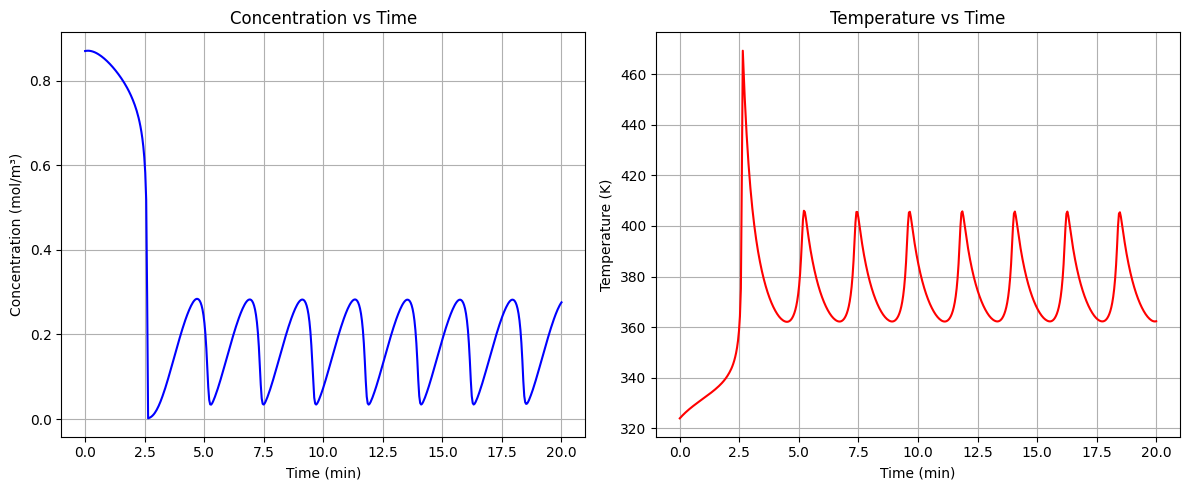

In [7]:
from tqdm import tqdm
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q   = 100.0     # Flowrate [L/min]
cAf = 1.0       # Inlet feed concentration [mol/L]

Tf  = 350.0     # Inlet feed temperature [K]
Tc  = 305.0     # Coolant temperature [K]
cA0 = 0.87       # Initial concentration [mol/L]
T0  = 324   # Initial temperature [K]

# Initial Conditions
y0 = [cA0, T0]

# Rate constant as a function of temperature
def k(T):
    return k0 * np.exp(-Ea / (R * T))

# CSTR model
def cstr_model(t, y):
    cA, T = y
    dcAdt = (q/V)*(cAf - cA) - k(T)*cA
    dTdt = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
    return [dcAdt, dTdt]

# Time span and evaluation points
t_span = (0, 20)  # simulate for 1 minute due to fast dynamics
t_eval = np.linspace(*t_span, 500)

# Solve the ODEs
solution = solve_ivp(cstr_model, t_span, y0, t_eval=t_eval)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(solution.t, solution.y[0], label='$C_A$', color='blue')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration vs Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(solution.t, solution.y[1], label='T', color='red')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (K)')
plt.title('Temperature vs Time')
plt.grid(True)

plt.tight_layout()
plt.show()


### PID

In [8]:
class PID:
    def __init__(self, Kp, Ki, Kd, setpoint):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.integral = 0.0
        self.prev_error = 0.0

    def update(self, measured_value, dt):
        error = self.setpoint - measured_value
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt if dt > 0 else 0.0

        output = (
            self.Kp * error +
            self.Ki * self.integral +
            self.Kd * derivative
        )

        self.prev_error = error
        return output


In [9]:
# CSTR model
def system_dynamics(t, y, p):
    cA, T = y
    dcAdt = (q/V)*(cAf - cA) - k(T)*cA
    dTdt = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(p-T)
    return [dcAdt, dTdt]


100%|██████████| 199/199 [00:00<00:00, 8195.54it/s]


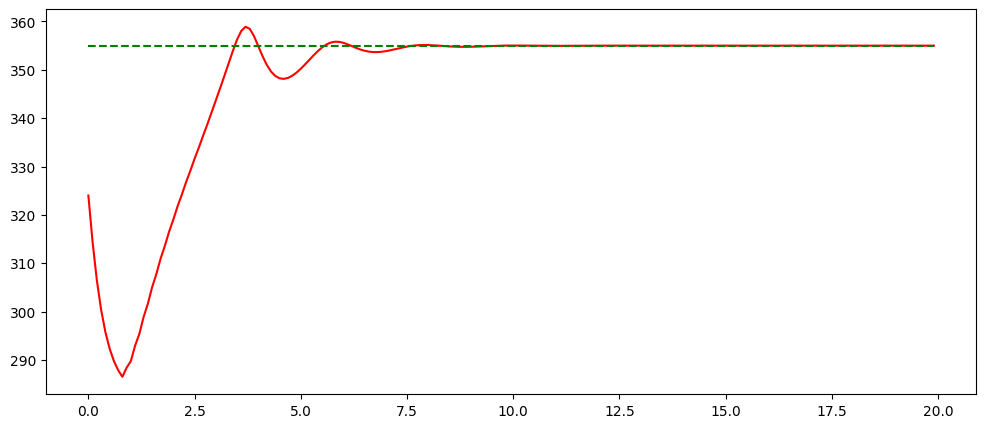

In [18]:
T_START, T_END = 0, 20
dt = 0.1
time = np.arange(T_START, T_END, dt)

setpoint = 355 # K

pid = PID(Kp=2.3, Ki=2.1, Kd=0.3, setpoint=setpoint)

concentration = cA0
temperature = T0
C_hist = [cA0]
T_hist = [T0]
u_hist = [Tc]
t_hist = [time[0]]

for i in tqdm(range(1, len(time))):
    t = time[i-1]
    p = pid.update(temperature, dt)
    p = np.clip(p, 250, 350)
    sol = solve_ivp(system_dynamics, [t,t+dt], [concentration,temperature], args=(p,), t_eval=[t+dt])
    concentration, temperature = sol.y[:, -1]
    C_hist.append(concentration)
    T_hist.append(temperature)
    u_hist.append(p)
    t_hist.append(t+dt)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(t_hist, T_hist, label='T', color='red')
plt.plot(t_hist, [pid.setpoint]*len(t_hist), label='Setpoint', color='green', linestyle='--')
plt.show()